In [1]:
from cortexlib.utils import file as futils
from cortexlib.mouse import CortexlabMouse
from cortexlib.images import CortexlabImages
from cortexlib.vgg19 import PreTrainedVGG19Model, PoolingMode
from cortexlib.predictor import NeuralResponsePredictor
from cortexlib.utils.plotting import simclr_colours
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.logging import Logger
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

logger = Logger()
set_global_seed()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

17:17:42 | INFO     | ℹ️ This notebook is running for mouse m03_d4


In [3]:
mouse = CortexlabMouse(mouse_id=MOUSE_ID)

logger.progress(f"Computing null distributions for all neurons in mouse {mouse.id}")
null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
logger.success(f"Null distributions computed")

real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

logger.info(f"Neural responses shape: {neural_responses.shape}")

17:17:42 | INFO     | ⏳ Computing null distributions for all neurons in mouse m03_d4...
17:18:04 | SUCCESS  | ✅ Null distributions computed!
17:18:05 | INFO     | ℹ️ Neural responses shape: (1573, 2, 500)


In [4]:
pca = PCA(100)
neural_data_pcs = pca.fit_transform(neural_responses_mean)
pc1_neural_data = neural_data_pcs[:, 0]
print(pc1_neural_data.shape)

(1573,)


In [5]:
futils.save_filtered_neural_data(
    mouse_id=mouse.id,
    neural_responses=neural_responses,
    neural_responses_mean=neural_responses_mean)

17:18:05 | INFO     | ℹ️ Skipping save, file already exists at /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m03_d4/_neural_data/neural_data_mouse_m03_d4.pt


In [6]:
vgg19 = PreTrainedVGG19Model(pooling_mode=PoolingMode.AVGPOOL)

settings = vgg19.get_image_settings()
images = CortexlabImages(
    size=settings['size'],
    channels=settings['channels'],
    normalise_mean=settings['mean'], 
    normalise_std=settings['std'],
    rescale_per_image=settings['rescale_per_image'],
)

logger.progress("Loading and preprocessing images shown to mouse")
image_dataset = images.load_images_shown_to_mouse(mouse.image_ids)
logger.success("Images processed")

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
17:18:05 | INFO     | ⏳ Loading and preprocessing images shown to mouse...
17:18:20 | SUCCESS  | ✅ Images processed!


In [7]:
# logger.progress("VGG19: extracting features from images shown to mouse")
# vgg19_feats, labels = vgg19.extract_features_with_pooling(image_dataset)
# logger.success("VGG19 features extracted")

# for layer, feats in vgg19_feats.items():
#     logger.info(f"{layer} feats shape: {tuple(feats.shape)}")

In [8]:
# futils.save_model_features(model=futils.Model.VGG19, mouse_id=mouse.id, features=vgg19_feats, labels=labels)

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models

# ---- Load VGG19 pretrained model ----
vgg = models.vgg19(pretrained=True).eval().to('cuda' if torch.cuda.is_available() else 'cpu')
vgg_features = vgg.features
vgg_classifier = vgg.classifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Specify target layers ----
layer_indices = {
    'conv2_2': '9', 
    'conv3_4': '18',
    'conv4_4': '27',
    'conv5_4': '36' 
}
target_layers = ['conv2_2', 'conv3_4', 'conv4_4', 'conv5_4', 'fc2']

# ---- Feature extraction from image dataset ----
def extract_vgg_features(image_dataset, layer_indices):
    hooks_outputs = {name: [] for name in layer_indices}

    def make_hook(name):
        def hook(module, input, output):
            hooks_outputs[name].append(output.view(output.size(0), -1).detach().cpu())
        return hook

    handles = []
    for name, idx in layer_indices.items():
        layer = dict(vgg_features.named_modules())[idx]
        handles.append(layer.register_forward_hook(make_hook(name)))

    with torch.no_grad():
        for img_tensor, _ in image_dataset:
            img_tensor = img_tensor.unsqueeze(0).to(device)
            _ = vgg_features(img_tensor)

    for h in handles:
        h.remove()

    return {name: torch.cat(hooks_outputs[name], dim=0).numpy() for name in hooks_outputs}

vgg_feats = extract_vgg_features(image_dataset, layer_indices)

# ---- Extract fc2 features ----
fc2_feats = []
with torch.no_grad():
    for img_tensor, _ in image_dataset:
        img_tensor = img_tensor.unsqueeze(0).to(device)
        x = vgg_features(img_tensor)
        x = nn.AdaptiveAvgPool2d((7, 7))(x)
        x = torch.flatten(x, 1)
        x = vgg_classifier[:5](x)  # Up to and including fc2
        fc2_feats.append(x.squeeze().cpu())
vgg_feats['fc2'] = torch.stack(fc2_feats).numpy()

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# ---- Ridge regression to neural PC1 ----
def regressor(X, Y):
    from sklearn.linear_model import RidgeCV
    alphas = np.logspace(1, 7, 20)
    ridge = RidgeCV(alphas=alphas, store_cv_values=True)
    ridge.fit(X, Y)
    return ridge

ridge_vgg = {layer: regressor(feats, pc1_neural_data) for layer, feats in vgg_feats.items()}

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1

In [11]:
# ---- L2 penalty for regularisation ----
def l2_penalty(img, lam=0.001):
    return lam * torch.sum(img ** 2)

# ---- Synthetic image generation ----
def generate_synthetic_img_vgg(layer_name, ridge, iterations=200, regularise=True):
    vgg = models.vgg19(pretrained=True).eval().to(device)
    feat_out = {}

    if layer_name != 'fc2':
        model_part = vgg.features
        hook_layer = dict(model_part.named_modules())[layer_indices[layer_name]]
    else:
        model_part = vgg
        hook_layer = vgg.classifier[4]

    def hook_fn(module, input, output):
        feat_out[layer_name] = output

    handle = hook_layer.register_forward_hook(hook_fn)

    ridge_weights = torch.tensor(ridge.coef_, dtype=torch.float32, device=device).unsqueeze(0)
    synthetic_image = torch.randn(1, 1, 224, 224, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([synthetic_image], lr=0.05)

    for _ in range(iterations):
        optimizer.zero_grad()

        x = synthetic_image.repeat(1, 3, 1, 1) # Make it RGB
        if layer_name != 'fc2':
            _ = model_part(x)
        else:
            x = vgg_features(x)
            x = nn.AdaptiveAvgPool2d((7, 7))(x)
            x = torch.flatten(x, 1)
            x = vgg.classifier[0](x)  # fc1
            x = vgg.classifier[1](x)  # ReLU
            x = vgg.classifier[2](x)  # Dropout
            x = vgg.classifier[3](x)  # fc2
            _ = vgg.classifier[4](x)  # ReLU — this triggers the hook

        feats = feat_out[layer_name].view(1, -1)
        score = torch.matmul(feats, ridge_weights.t()).squeeze()
        loss = -score + (l2_penalty(synthetic_image) if regularise else 0)

        loss.backward()
        optimizer.step()
        synthetic_image.data.clamp_(0, 1)

    handle.remove()

    img_np = synthetic_image.detach().cpu().squeeze().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    return img_np

# ---- Generate and plot all synthetic images ----
images_vgg = [generate_synthetic_img_vgg(layer, ridge_vgg[layer]) for layer in target_layers]

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


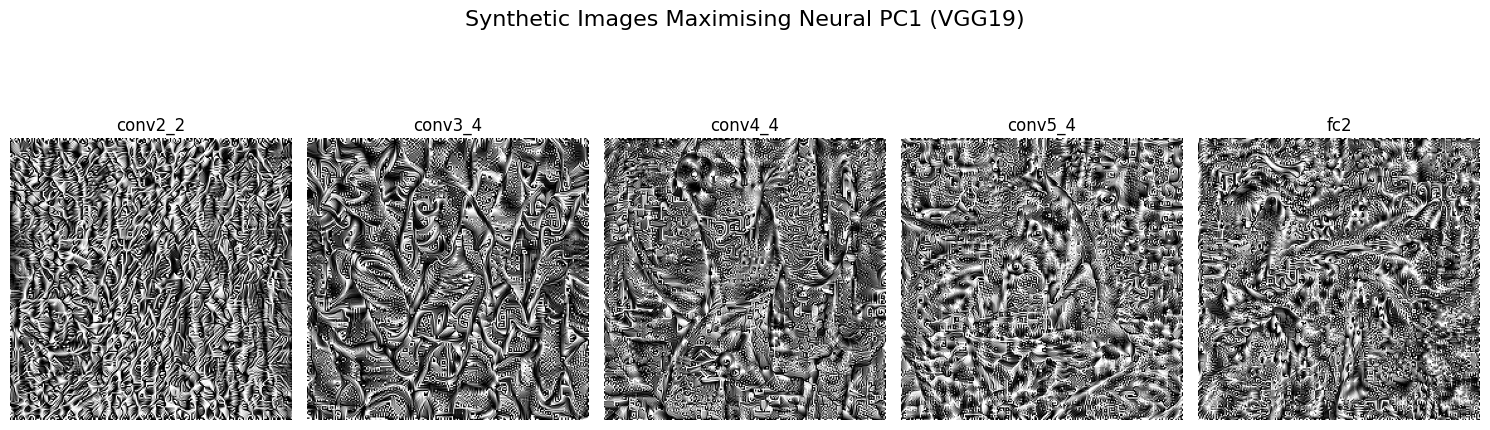

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for ax, img, name in zip(axs, images_vgg, target_layers):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)

plt.suptitle("Synthetic Images Maximising Neural PC1 (VGG19)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()